## BANDIT IV

In [1]:
import numpy as np
from scipy.stats import t as t_law
import matplotlib.pyplot as plt
from tqdm import tqdm
from icecream import ic
from numpy.linalg import inv

colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
s_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [2]:
#game parameters
n_iter = 50         #number of simulations
T = 100             #time horizon
sigma_iv = 0.1         #standard deviation of endogenous noise
sigma_y = 0.1

K = 3       #number of bandits 
k = 10      #dim of Z
d = 5       #dimension of X

Gamma_star = np.random.randn(k,d)   # arms x features
Beta_star = np.random.randn(d)      # features

#algorithm parameters
gamma_z = 0.1 
gamma_x = 0.1
G_t = [1 for _ in range(T)]
B_t = [1 for _ in range(T)]

assert k >= d #assumption

#intializing estimated parameter matrics
U_0 = np.eye(k)*gamma_z
V_0 = np.zeros((k,d))
W_0 = np.eye(d)*gamma_x
Q_0 = np.zeros((d,1))
 
#confidence sets #fill this out
C_1s = []
C_2s = []


    


In [3]:
def sample_Z_X(): 
    # Construct Z,X
    e = np.random.randn(K,1)                                           #endogenous component of X. 
    Z_dist = np.random.randn(K, k)                                     #instrumental variable. K arms. Related to X but exogenous wrt Y

    # rho = 1-2*np.random.binomial(1, 0.2) #random noise scaler for Y
    u = np.random.randn(K,d)

    v = Beta_star.T @ u[...,None] + e         #scalar
    v = v.squeeze()
    
    X_dist = (Gamma_star.T @ Z_dist[...,None]).squeeze() + u  # d  (IV + exogenous component + endogenous component)

    return Z_dist, X_dist, v[...,None]

In [4]:
regret = np.zeros((n_iter, T))

for iteration in tqdm(range(n_iter)):

    Z_dist, X_dist, v = sample_Z_X()

    # choose arm (x) associated with randomly chosen z
    idx = np.random.choice(np.arange(Z_dist.shape[0]))
    # select and observe reward
    z = Z_dist[idx] ; x = X_dist[idx] ; v = v[idx]
    y = ((Gamma_star @ Beta_star).T @ z.T) + v   #scalar
    z = z[...,None] ; x = x[...,None]
    Z = z ; X = x ; Y = y

    #intializing estimated parameter matrics
    U_0 = np.eye(k)*gamma_z         # k x k
    V_0 = np.zeros((k,d))           # k x d
    W_0 = np.eye(d)*gamma_x         # d x d
    Q_0 = np.zeros((d,1))           # d x 1
    
    #confidence sets #fill this out
    C_1s = [] ; C_2s = []
    U_s = [] ; W_s = []

    for t in range(1,T):

        U_t = U_0 + z @ z.T
        V_t = V_0 + z @ x.T     
        
        Gamma_est = inv(U_t) @ V_t          #shape : d x k

        X_est = (Z.T @ Gamma_est).T         #shape : d x (n rounds so far..) (different from paper)

        W_t = W_0 + X_est @ X_est.T         #operation is other way in paper but that yield 1x1 (not dxd)

        Q_t = Q_0 + (X_est @ Y)[...,None]       #had to remove transpose

        Beta_est = inv(W_t) @ Q_t           #shape : k x 1

        # add to set once so that it isnt empty?
        U_s.append(U_t) ; W_s.append(W_t)          
        if True: #len(C_1s)==0:
            C_1s.append(Gamma_est)
        
        gdiff = [(Gamma_star[:,i] - Gamma_est[:,i])[...,None] for i in range(Gamma_est.shape[1])] # ||x||_A = sqrt(x'Ax) (index on columns) 

        if all([np.sqrt(g.T @ U_s[t-1] @ g) <= G_t[t-1] for g in gdiff]): 
            C_1s.append(Gamma_est)

        if True: #len(C_2s)==0:
            C_2s.append(Beta_est)
        b = (Beta_star[...,None] - Beta_est)
        if np.sqrt(b.T @ W_s[t-1] @ b) <= B_t[t]:
            C_2s.append(Beta_est)


        # nature reveals Z_t
        Z_dist, X_dist, v = sample_Z_X()
        # select z 
        idx = np.argmax(
                    [np.max(
                        [np.max(
                            [((gamma.T @ z).squeeze() @ beta) for beta in C_2s]
                        ) for gamma in C_1s]
                    ) for z in Z_dist] #fix this z
                )

        #play x corresponding to that z 
        z = Z_dist[idx] ; x = X_dist[idx] ; v = v[idx]
        y = ((Gamma_star @ Beta_star).T @ z.T) + v   #scalar
        z = z[...,None] ; x = x[...,None] 

        #update X, Z, Y
        Z = np.hstack([Z, z])
        X = np.hstack([X, x])
        Y = np.hstack([Y, y])
        
        U_0, V_0, W_0, Q_0 = U_t, V_t, W_t, Q_t


        #getting optimal arm
        idx_star = np.argmax([Gamma_star.T @ z_ta for z_ta in Z_dist])
        z_star = Z_dist[idx]
        y_star = np.dot((Gamma_star.T @ z_star), Beta_star)
        y_ = np.dot((Gamma_est.T @ z_star), Beta_est)

        regret[iteration, t] += np.abs(y_star - y_)
    

    


100%|██████████| 50/50 [02:30<00:00,  3.00s/it]


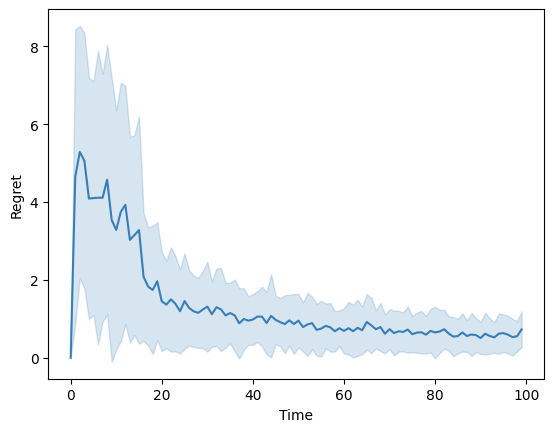

In [6]:
mean_regret = np.mean(regret, axis=0)
std_regret = np.std(regret, axis=0)


plt.plot(np.arange(T), mean_regret, color=colors[0])
plt.fill_between(np.arange(T), mean_regret - std_regret, mean_regret + std_regret, color=s_colors[0],alpha=0.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.show()
